# Posture detection for team wellbeing app
* Ported to ONNX runtime
* Simplified processing from https://github.com/Daniil-Osokin/lightweight-human-pose-estimation.pytorch 
* Added heatmap postprocessing & posture scoring (check out scripts/simplified_functions.py for details)
* Bonus: __Live demo at the end!__

In [11]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

from scripts.simplified_functions import sigmoid, normalize, find_distance, find_peaks, choose_best_peak, \
                                        get_keypoint_locations, get_signals_from_keypoints, \
                                        get_scores_from_signals, preprocess_image

import onnx
import onnxruntime as ort

# Should be CPU by default, which is ok
print('Device: {}'.format(ort.get_device()))

Device: CPU


## Defining some variables

['nose', 'neck', 'r_sho', 'l_sho', 'r_eye', 'l_eye']


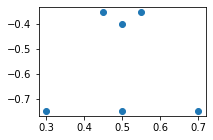

In [12]:
# We will only be using 6 of the key points
kpt_names = ['nose', 'neck', 'r_sho', 'r_elb', 'r_wri', 'l_sho', 'l_elb', 
             'l_wri', 'r_hip', 'r_knee', 'r_ank', 'l_hip', 'l_knee',
             'l_ank', 'r_eye', 'l_eye', 'r_ear', 'l_ear']

# points of interest 
poi = [0, 1, 2, 5, 14, 15]
print([kpt_names[i] for i in poi])

# default positions (y,x) of different parts with the origin on the top left
default_keypoints = [(0.4,0.5), (0.75,0.5), (0.75,0.3), (0.75,0.7),(0.35,0.45), (0.35,0.55)]

# they're really just telling the algorithm roughly where to look for these keypoints by default
plt.figure(figsize=(3,2)); plt.scatter([x[1] for x in default_keypoints], [-x[0] for x in default_keypoints]);

## Processing
### Workflow within the app:
1. **Calibration**
    * First, we need to do **Steps 0 to 4** on a calibration image to get `calib_signals`.
        * In the code below, I'm using the `default_keypoints` as a placeholder for calibration keypoints, but in the app, we want to get their actual "good posture" keypoints.
2. **Evaluation**
    * We do **Steps 0 to 4** on a current image to get the current `signals`.
    * Then do **Step 5 and 6** which compares current `signals` with `calib_signals` to get the final score

In [3]:
calib_keypoints = default_keypoints

In [8]:
"""
0. load .onnx and start onnx session
1. load test image (or acquire it from webcam)
2. inference is run here, will take about 2 seconds. the output will be heatmaps
3. postprocess heatmaps to get keypoint locations
4. process keypoint locations to get signals
"""
model = onnx.load("pose360.onnx")
sess = ort.InferenceSession('pose360small.onnx')

img = cv2.imread('calibration/test2.jpg')
input_tensor = preprocess_image(img)

output_tensor = sess.run(None, {'input': input_tensor})

keypoint_locations = get_keypoint_locations(output_tensor, poi, calib_keypoints)

signals = get_signals_from_keypoints(keypoint_locations)

"""
5. scoring by comparing signals with calibration signals (4 scores from 0-1)
"""
calib_signals = get_signals_from_keypoints(calib_keypoints)
scores = get_scores_from_signals(signals, calib_signals)

"""
6. average the 4 scores to get final score (from 0-1)
"""
final_score = sum(scores)/4
print(final_score)

#### End of code needed for integration with windows app
---
---

## Live Demo
#### 1. Calibration: Sit in a correct posture, then run the cell below.
* hold it there until the image shows up, make sure your shoulders and head are visible

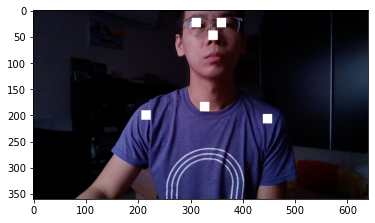

In [9]:
def draw_box(img, pos, size=9):
    h,w,_ = img.shape
    y, x = int(pos[0]*h), int(pos[1]*w)
    y1, y2 = max(y-size, 0), min(y+size, h-1)
    x1, x2 = max(x-size, 0), min(x+size, w-1)
    img[y1:y2, x1:x2, :] = 255
    
cap = cv2.VideoCapture(0)
cap.set(3,640)
cap.set(4,360)
ret, calib_img = cap.read()

calib_input = preprocess_image(calib_img)
calib_output = sess.run(None, {'input': calib_input})
calib_keypoints = get_keypoint_locations(calib_output, poi, default_keypoints)
calib_signals = get_signals_from_keypoints(calib_keypoints)

for keypoint in calib_keypoints:
    draw_box(calib_img, keypoint)
plt.imshow(cv2.cvtColor(calib_img, cv2.COLOR_BGR2RGB))
cap.release()

#### 2. Live demo, run the cell below.
* you must have all 6 parts visible for the demo to work, if not it'll tell you how many is missing
* because it's running on CPU only it might be quite slow (1 hz)

In [10]:
import pandas as pd
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure

def generate_live_plot4(time_series, window_size=5, max_data_length=20):
    fig = Figure(figsize=(4, 6), dpi=100)
    canvas = FigureCanvasAgg(fig)
    
    labels = ['shoulder uprightness', 'neck uprightness', 'eye-screen distance', '"non-slouchness"']
    colors = ['gray','gray','gray','gray']
    axs = fig.subplots(4)
    for i,col in enumerate(time_series.columns):
        axs[i].set_ylim([-0.2,1.2])
        time_series[col].reset_index(drop=True).rolling(window_size,min_periods=1).mean().iloc[-max_data_length:].plot.area(ax=axs[i],label=labels[i],color=colors[i], alpha=0.3)
        axs[i].legend(loc='upper left')
        score = time_series[col].iloc[-1]*0.3
        axs[i].set_facecolor((1-score, 0.7+score, 0.7))
    canvas.draw()
    s, (width, height) = canvas.print_to_buffer()
    live_plot = np.frombuffer(s, np.uint8).reshape((height, width, 4))
    return live_plot

cap = cv2.VideoCapture(0)
cap.set(3,640)
cap.set(4,360)
ret, calib_img = cap.read()
time_series = pd.DataFrame()
n = 0
while(True):
    ret, img = cap.read()
    if (img is not None):     
        input_tensor = preprocess_image(img)

        # inference is run here, will take about 2 seconds 
        output_tensor = sess.run(None, {'input': input_tensor})

        # ONNX output --> keypoint locations --> signals ---> score
        keypoint_locations = get_keypoint_locations(output_tensor, poi, calib_keypoints)
        
        # if there's any point missing, get_keypoint_locations() will output None
        if keypoint_locations is None:
            continue
            
        signals = get_signals_from_keypoints(keypoint_locations)

        # to get scores, calibration signals are required
        scores = get_scores_from_signals(signals, calib_signals)

        time_series = time_series.append([scores])

        for keypoint in keypoint_locations:
            draw_box(img, keypoint)

        live_plot = generate_live_plot4(time_series, 5,20)[:,:,:3][:,:,::-1]   

        cv2.imshow('video', img)
        cv2.imshow('plot', live_plot)
     
    if cv2.waitKey(1) == 27: # when escape key is pressed
        break

cap.release()
cv2.destroyAllWindows()

1 Keypoints missing!


In [63]:
cap.release()
cv2.destroyAllWindows()

### STUFF FOR DEBUGGING
not part of the integration!

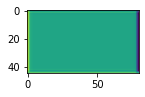

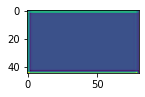

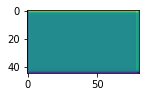

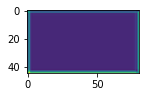

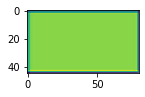

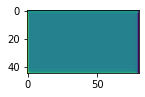

In [10]:
# Take a look at the heatmaps to make sure theyre ok
for i in poi:
    heatmap = np.squeeze(output_tensor[0][:,i,:,:]) # convert it back to 2D array
    plt.figure(figsize=(2,2))
    plt.imshow(heatmap); plt.show()

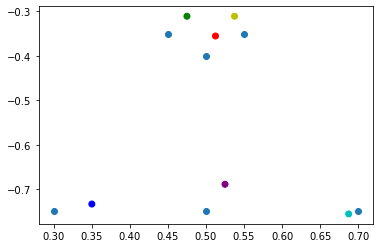

In [261]:
plt.scatter(x=[x[1]/80 for x in keypoint_locations], y=[-x[0]/45 for x in keypoint_locations], c=['r','purple','b','c','g','y'])
plt.scatter(x=[x[1] for x in calib if x != None], y=[-x[0] for x in calib if x != None])
plt.show()

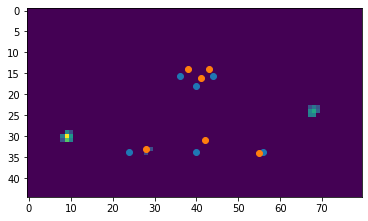

In [25]:
plt.imshow(np.squeeze(output_tensor[0][:,2,:,:]))
plt.scatter(x=[x[1]*80 for x in calib if x != None], y=[x[0]*45 for x in calib if x != None])
plt.scatter(x=[x[1]*80 for x in keypoint_locations if x != None], y=[x[0]*45 for x in keypoint_locations if x != None])

plt.show()

In [ ]:
# I roughly came up w these numbers for now. 
calib = [(0.4,0.5), (0.75,0.5), (0.75,0.3), None, None, 
         (0.75,0.7), None, None, None, None, None, None, None, None,
         (0.35,0.45), (0.35,0.55), None, None]